## **GNN(Graph Neural Network) 이란 ?**
- 이미지 데이터에 CNN이 쓰이듯, 그래프 (노드 + 엣지 구조)를 처리하기 위한 대표적인 모델


> New Feature of node v=AGGREGATE(Features of neighbors of v)



↪ 노드는 이웃 정보의 정보를 모아서 자기 feature를 업데이트 하는 형태


## **GCN(Graph Convolutional Network) 이란 ?**
- GNN (Graph Neural Network)의 한 종류로 그래프 위에 합성곱 연산을 정의하여 노드 feature 학습을 수행함

- 기존의 CNN이 이미지에서 주변 픽셀을 고려하는 것처럼, GCN은 그래프에서 이웃 노드 정보를 반영


### 📌 **GCN Layer 기본 수식**

$$
H^{(l+1)} = \sigma\left( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)} \right)
$$



$ H^{(l)}=$ l번째 레이어의 입력 피처 행렬

$ H^{(l+1)}=$ l+1번째 레이어의 출력 피처

$ W^{(l)}=$ 학습 가능한 가중치 행렬

$ \hat{A} = A + I $: 자기 자신을 포함한 인접 행렬 (self-loop 포함)
  - A는 그래프의 연결관계를 나타내는 것으로 데이터에서 주어지는 그래프 구조!
  - 노드가 이웃 노드이 정보만 받으면 자기 자신의 정보는 반영이 되지 않기에 자기 자신도 이웃으로 취급하기 위해 + I (identity matrix)를 더해줌
    ▶ "self-loop"

$ \hat{D} = $  $\hat{A}$의 degree 행렬
  - 그래프에서 각 노드가 연결된 수(=degree)를 대각선에 담은 행렬
  - 만약 어떤 노드가 3개의 노드와 연결되어 있다면, 그 노드의 degree는 3이고, degree 행렬에서는 해당 대각 원소가 3 이 됨
  - 따라서 A 행렬의 각 row 별 합이 D의 각 대각원소가 되는 것! (이때 나머지는 모두 0)

🚫 이때 A는 0, 1 로 이루어진 행렬 (자기 자신, 또는 그래프 구조에서 이어져 있으면 1, 아니면 0으로) 로 연결 여부를 알려줍니다. **하지만 많이 연결되어있는 노드가 있다면, 정보를 과하게 주는 문제 발생**


✅  **D를 통해 연결된 이웃 정보를 정규화해서 이웃 수에 따라 균형 있게 평균 정보를 주도록 합니다.**

$ \sigma = $ 비선형 활성화 함수 (예: ReLU)


🧠 설명:

1. 각 노드는 이웃 노드로부터 정보 (feature) 를 평균(또는 합산)하여 전달받음

2. 이 정보를 학습 가능한 가중치 행렬로 선형변환

3. 비선형 함수로 처리하여 다음 레이어로 넘김

## **1) GCN 코드 해석**
- 아래 코드는 GraphConvolution을 직접 구현한 코드입니다
- 위의 설명을 참고하여 각 코드에 주석을 달아 설명하고, 코드를 실행시켜 주세요! 🙂

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvolution(nn.Module):  # 그래프 합성곱 레이어 정의
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()  # 부모 클래스 nn.Module의 __init__() 호출
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))  # weight 정의
        # bias 정의
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()  # 파라미터 초기화

    def reset_parameters(self):  # 파라미터 초기화 함수 정의
        nn.init.xavier_uniform_(self.weight)  # xavier 초기화
        if self.bias is not None:
            nn.init.zeros_(self.bias)  # bias는 0으로 초기화

    def forward(self, x, adj):  # 순전파
        """
        input: 노드 피처 행렬 (X), shape = [num_nodes, in_features]
        adj: 정규화된 인접 행렬 (A_hat), shape = [num_nodes, num_nodes]
        """
        support = torch.mm(x, self.weight)              # X * W
        output = torch.mm(adj, support)                 # A_hat * (X * W)
        if self.bias is not None:
            output += self.bias
        return output

## **2) GCN 사용법 예시**

- 아래의 코드 빈칸을 채우고, 앞에서 정의한 GraphConvolution로 GCN 한층을 거친 후 새로운 노드 피처가 어떻게 나오는지 확인해봅시다 😀

In [2]:
# 노드 수: N, 입력 피처: F_in, 출력 피처: F_out
N = 4
F_in = 5
F_out = 2

# 임의의 노드 피처와 adjacency matrix
torch.manual_seed(42)
x = torch.rand(N, F_in)
print('x')
print('----------------')
print(x)
print('----------------')

# Adjacency matrix (4x4) 예시 + self-loop + normalize
adj = torch.tensor([
    [0, 1, 0, 0], # 예시로, 0번째 노드와 1번째 노드는 연결관계가 있고 (1)
    [1, 0, 1, 1], # 0번째 노드와 4번째 노드는 연결관계가 없는 것 (0)
    [0, 1, 0, 1],
    [0, 1, 1, 0]
], dtype=torch.float32)


# Add self-loops 로 identity matrix 추가하여 자기 자신과도 연결관계를 갖도록 하기
adj = adj + torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32)


# Degree matrix 정의하기
deg = torch.sum(adj, dim=1)


D_inv_sqrt = torch.diag(1.0 / torch.sqrt(deg))    # 힌트: D^(-1/2)를 구하는 것!
adj_normalized = torch.matmul(torch.matmul(D_inv_sqrt, adj), D_inv_sqrt) # 힌트: 위 수식에서 D^(-1/2)*A*D^(-1/2)를 구하는 것!

# GCN Layer
gcn = GraphConvolution(F_in, F_out)
out = gcn(x, adj_normalized)

print('After one GCN layer')
print('----------------')
print(out)
print('----------------')

x
----------------
tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274]])
----------------
After one GCN layer
----------------
tensor([[-1.0211, -0.6095],
        [-1.3835, -0.8846],
        [-1.1007, -0.7813],
        [-1.1007, -0.7813]], grad_fn=<AddBackward0>)
----------------


## **3) GCN 모델 학습**

- 데이터에 실습해보기 위해 GCN 모델을 위에서 정의한 GraphConvoultion을 사용해서 정의해봅시다!

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00


###  **데이터셋 로딩**
- Planetoid 데이터를 사용해보겠습니다!
  - Citation Network로 논문 (노드) 들이 서로 인용한 관계 (edge)를 가진 하나의 큰 그래프로 되어있는 구조 입니다.

- dataset[0]으로 Cora 전체를 담은 하나의 큰 그래프를 가져오겠습니다.

In [4]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from torch_geometric.utils import to_dense_adj
from collections import Counter

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


|속성|설명|
|---|---|
|*x*|노드 feature matrix로  [2708, 1433]|
|*egde_index*|그래프의 edge 정보|
|*y*|노드 label|
|*train_mask*|학습에 사용할 노드 index mask|
|*val_mask*|검증용 mask|
|*test_mask*|테스트용 mask|

- 각 속성에 대한 설명은 다음과 같습니다.
- **따라서 우리는 1433개의 feature를 가진 2708개의 node를 y (7개의 label) 분류하는 문제를 풀어보겠습니다!**
- 데이터를 확인하기 위해 아래 시각화 코드를 실행시켜 주세요 🐋

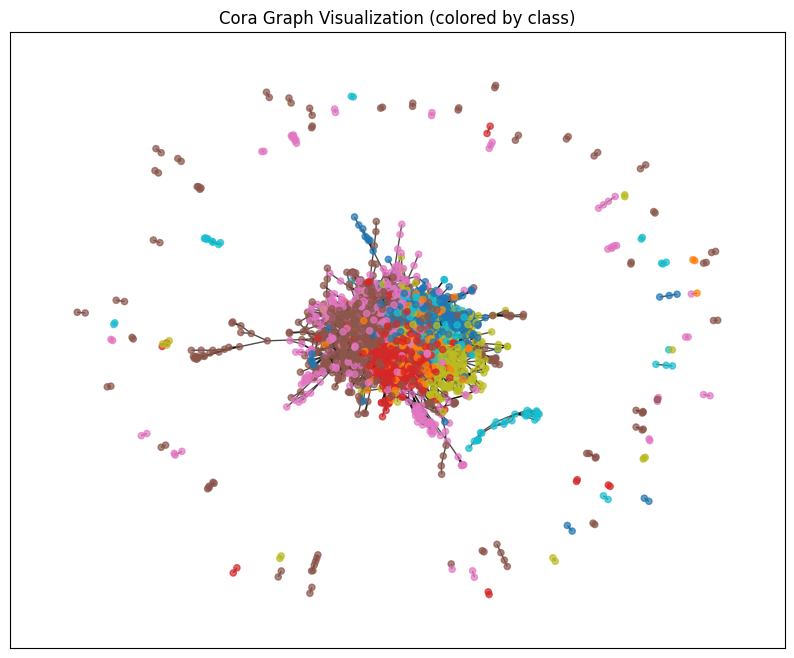

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
# 네트워크 시각화를 위해 PyG → NetworkX 그래프로 변환
G = to_networkx(data, to_undirected=True)

# 시각화용 노드 컬러: 클래스(y) 값
node_color = data.y.numpy()

# 시각화
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    node_size=20,
    cmap=plt.get_cmap('tab10'),
    node_color=node_color,
    with_labels=False,
    alpha=0.7
)
plt.title("Cora Graph Visualization (colored by class)")
plt.show()

In [6]:
# 데이터를 device에 올려주세요!
data = dataset[0].to("cuda" if torch.cuda.is_available() else "cpu")
device = data.x.device

### **GCN Model 정의**

In [12]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(in_dim, hidden_dim)                          #힌트: 앞에서 정의한 GraphConvolution을 사용해주세요!
        self.gc2 = GraphConvolution(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        # edge_index → 인접 행렬로 변환 (sparse → dense)
        adj = to_dense_adj(edge_index)[0] # [num_nodes, num_nodes] 로 shape 맞추기
        # 정규화하기 -> (D^(-1/2) A D^(-1/2)) 를 adj_norm으로 넣는 것이 목적!
        deg = torch.sum(adj, dim=1)                    #힌트: degree vector 생성
        deg_inv_sqrt = 1.0 / torch.sqrt(deg)      #힌트: D^(-1/2)의 대각 원소만 추출한 벡터 생성
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0 # 불안정한 학습 방지용
        D_inv_sqrt = torch.diag(deg_inv_sqrt)         #힌트:[N x N] 대각 행렬 생성 -> D^(-1/2) matrix가 되는 것!
        adj_norm = torch.matmul(torch.matmul(D_inv_sqrt, adj), D_inv_sqrt)  #최종적으로 (D^(-1/2) A D^(-1/2)) 생성
        x = self.gc1(x, adj_norm)
        x = F.relu(x) # 비활성화 함수로 relu를 사용하겠습니다.
        x = self.gc2(x,adj_norm)
        return x

### **train을 위한 setting**


-  hidden_dim은 원하시는 대로 자유롭게 변경해주셔도 됩니다!
- 옵티마이저는 Adam을 사용하겠습니다
- 마찬가지로, 옵티마이저와 learning rate 또한 자유롭게 변경 가능합니다!
- 다중분류로 cross entropy loss를 사용하도록 하겠습니다

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 정의
model = GCN(in_dim=dataset.num_node_features, hidden_dim=16, out_dim=dataset.num_classes).to(device)

# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 다중분류를 위한 loss 정의
loss_fn = torch.nn.CrossEntropyLoss()

###  **학습 루프 설정**

In [14]:
loss_list = []
epoch_loss_list = []
step_interval = 10  # loss를 저장할 step 간격

def train():
    model.train()
    optimizer.zero_grad            #힌트: 옵티마이저 초기화하기
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()           #힌트: loss로 역전파
    optimizer.step()           #힌트: optimizer로 가중치 업데이트
    if step_interval:
        loss_list.append(loss.item())
    epoch_loss_list.append(loss.item())

### **test 데이터**

In [15]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    # 맞추면 1, 틀리면 0으로!
    correct = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum()
    acc = correct / int(data.test_mask.sum())
    return acc

### **학습 실행**
- 아래 코드를 실행시켜주세요!

In [16]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train()
    acc = test()
    print(f"Epoch {epoch}, Test Accuracy: {acc:.4f}, Avg Loss: {epoch_loss_list[-1]:.4f}")

Epoch 1, Test Accuracy: 0.4550, Avg Loss: 1.9490
Epoch 2, Test Accuracy: 0.4940, Avg Loss: 1.8365
Epoch 3, Test Accuracy: 0.4230, Avg Loss: 1.7162
Epoch 4, Test Accuracy: 0.3740, Avg Loss: 1.5760
Epoch 5, Test Accuracy: 0.3700, Avg Loss: 1.4302
Epoch 6, Test Accuracy: 0.3950, Avg Loss: 1.2915
Epoch 7, Test Accuracy: 0.4460, Avg Loss: 1.1634
Epoch 8, Test Accuracy: 0.4960, Avg Loss: 1.0456
Epoch 9, Test Accuracy: 0.5530, Avg Loss: 0.9353
Epoch 10, Test Accuracy: 0.6210, Avg Loss: 0.8317


### **Epoch 별 평균 loss 시각화**

- 아래 코드를 실행시켜주세요!

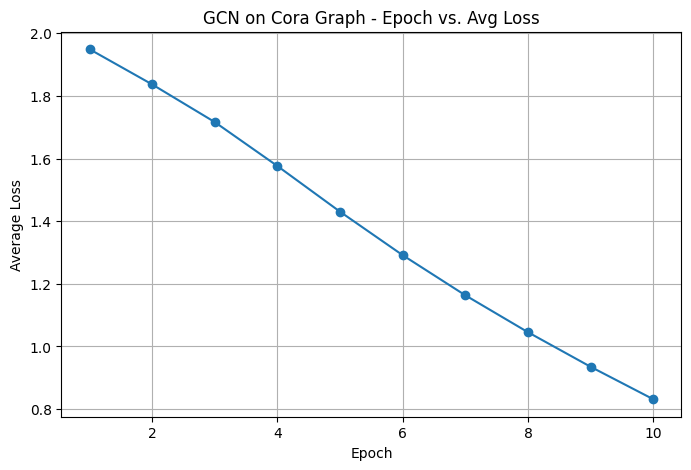

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), epoch_loss_list, marker='o')
plt.title("GCN on Cora Graph - Epoch vs. Avg Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

### **해당 마크다운 셀을 풀고 GCN에 대해 설명해주세요 ! 💡**

---

GCN은 graph convolution network의 약자로, 요소들 간의 연결관계가 포함된 데이터를 다루기 위한 모델이다.


```
graph input을 받아
graph conv layer를 통과하고 (*n 개층)
readout 층을 통과하여 행렬값을 일반화시키고
최종적으로 predictor 층에서 결과가 출력되게 된다

```



- 그래프 데이터를 처리하기 위해서는 행렬을 이용한다.
- adjacency matrix(인접 행렬)는 그래프의 연결관계를 표현한 행렬이다.
- feature matrix는 노드들의 특성정보를 반영하는 행렬이다.